A Neural network approach to composite model

In [23]:
# utils
import warnings

# data processing and handling pkgs
import pandas as pd
import numpy as np
from astral import LocationInfo
from astral.sun import sun


# plotting packages
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

# NN modelling packages
import keras


# custom methods
from custom_utils import *

# global settings
np.random.seed(27)
warnings.filterwarnings("ignore")

## Load data

In [24]:
data_path = "./data/"
file_name = "Data.csv"
data = pd.read_csv(data_path + file_name)
duplicate_indices = data.index.duplicated()
print(f"Number of duplicate indices: {duplicate_indices.sum()}")
data = first_preprocess(data, data_path)
data.head()

Number of duplicate indices: 0


ValueError: cannot reindex on an axis with duplicate labels

In [3]:
data.columns

Index(['space_heating', 'hot_water', 'sockets', 'lighting', 'bld_engcons',
       'car_chargers', 'weekend', 'bank_holiday', 'day_of_month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'daylight_hours', 'is_daylight', 'sine_hour',
       'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week',
       'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'sine_sunrise_hour', 'cos_sunrise_hour',
       'sine_sunset_hour', 'cos_sunset_hour'],
      dtype='object')

In [4]:
exo_columns = ['forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_visibility',
       'week_of_year', 'daylight_hours', 'is_daylight', 'sine_hour',
       'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week',
       'cos_day_of_week', 'sine_forecast_winddirection',
       'cos_forecast_winddirection', 'sine_sunrise_hour', 'cos_sunrise_hour',
       'sine_sunset_hour', 'cos_sunset_hour']
endo_columns = ['weekend', 'bank_holiday', 'day_of_month', 'year', "others"]
target_column = ["y"]
column_name = exo_columns + endo_columns  + target_column
train_date = "2023-01-01"
test_date = '2023-01-01'


class DataTransform:
    """
    An implementation to transform the data


    """
    def __init__(self):
        pass

    @staticmethod
    def get_scaled_data(raw_data, column_name):
        """
        """
        data_scaler, transformed_data = create_std_scaler(raw_data, column_name[:-1])
        target_scaler, transformed_target_data = create_std_scaler(raw_data, column_name[-1])
        
        transformed_data = pd.merge(transformed_data, transformed_target_data, left_index=True, right_index=True)
        return data_scaler, target_scaler, transformed_data

    def sh_transform(self, raw_data):
        """
        """
        column_name = "space_heating"
        raw_data = raw_data.rename(columns={"space_heating": "t-1"})
        raw_data["space_heating"] = raw_data["t-1"].shift(1)
        raw_data = raw_data.dropna(axis=0)
        column_names = raw_data.columns.tolist()
        data_scaler, target_scaler, transformed_data = self.get_scaled_data(raw_data, column_names)
        return data_scaler, target_scaler, transformed_data

    def others_transform(self, raw_data): 
        """
        """
        column_names = ["hot_water", "sockets", "lighting"]
        raw_data["others"] = raw_data[column_names].sum(axis=1)
        raw_data = raw_data.rename(columns={"others": "t-1"})
        raw_data["others"] = raw_data["t-1"].shift(1)
        raw_data = raw_data.drop(columns=column_names)
        raw_data = raw_data.dropna(axis=0)
        column_names = raw_data.columns.tolist()
        data_scaler, target_scaler, transformed_data = self.get_scaled_data(raw_data, column_names)
        return data_scaler, target_scaler, transformed_data

    def bldg_transform(self, raw_data):
        """
        """
        column_name = "bld_engcons"
        raw_data = raw_data.rename(columns={"bld_engcons": "y"})
        raw_data = raw_data[["y"]]
        raw_data["y"] = raw_data["y"].shift(1)
        raw_data = raw_data.dropna(axis=0)
        return raw_data

    def transform(self, raw_data, prepare_for):
        """
        Args:
            raw_data: pd.DataFrame: data to be preprocessed
            prepare_for: str: preprocess as per the model data form
    
        Returns:
            processed_data: dict: data frame consisting of the preprocessed data
    
        Raises:
            ValueError
        """
        if prepare_for == "space_heating":
            data_scaler, target_scaler, transformed_data = self.sh_transform(raw_data)
            self.space_heating = {"data_scaler": data_scaler, "target_scaler": target_scaler, "transformed_data": transformed_data}
        elif prepare_for == "others":
            data_scaler, target_scaler, transformed_data = self.others_transform(raw_data)
            self.others = {"data_scaler": data_scaler, "target_scaler": target_scaler, "transformed_data": transformed_data}
        elif prepare_for == "car_chargers":
            pass
        elif prepare_for == "building":
            transformed_data = self.bldg_transform(raw_data)

        # train validation - test split 
        preprocessed_data = {
            "train": transformed_data[transformed_data.index < train_date],
            "test": transformed_data[transformed_data.index >= test_date],
            # "validation": transformed_data[(transformed_data.index >= train_date) & (transformed_data.index < test_date)],
        }
        # check the data dimentions
        assert preprocessed_data["train"].shape[1] == preprocessed_data["test"].shape[1]
        # assert preprocessed_data["train"].shape[1] == preprocessed_data["validation"].shape[1]
        # assert preprocessed_data["test"].shape[1] == preprocessed_data["validation"].shape[1]
        return preprocessed_data
    
    
transform_pipeline = DataTransform()

# prepare the space heating data
space_heating_data = transform_pipeline.transform(data.copy(), "space_heating")

# prepare the others circuits data
others_data = transform_pipeline.transform(data.copy(), "others")

# prepare the building circuits data
building_data = transform_pipeline.transform(data.copy(), "building")

                              columns          mean    variance  scale_factor
0                                 t-1  9.214276e-01    1.409005      1.187015
1                           hot_water  1.735422e-01    0.141593      0.376289
2                             sockets  9.148717e-02    0.031124      0.176420
3                            lighting  2.290501e-01    0.032864      0.181283
4                         bld_engcons  1.415507e+00    1.803676      1.343010
5                        car_chargers  1.054802e+00    9.257305      3.042582
6                             weekend  2.867689e-01    0.204532      0.452253
7                        bank_holiday  2.462042e-02    0.024014      0.154965
8                        day_of_month  1.572111e+01   77.368659      8.795946
9                                year  2.022000e+03    0.666654      0.816489
10               forecast_temperature  1.184490e+01   21.640482      4.651933
11                 forecast_feelslike  9.345162e+00   29.479648 

In [5]:
others_data["train"].shape, building_data["train"].shape, space_heating_data["train"].shape

((17519, 31), (17519, 1), (17519, 33))

In [6]:
others_data["test"].shape, building_data["test"].shape, space_heating_data["test"].shape

((8760, 31), (8760, 1), (8760, 33))

In [7]:
others_data["train"].isna().sum()

space_heating                        0
bld_engcons                          0
car_chargers                         0
weekend                              0
bank_holiday                         0
day_of_month                         0
year                                 0
forecast_temperature                 0
forecast_feelslike                   0
forecast_weathertype                 0
forecast_windspeed                   0
forecast_uvindex                     0
forecast_precipitationprobability    0
forecast_visibility                  0
week_of_year                         0
daylight_hours                       0
is_daylight                          0
sine_hour                            0
cos_hour                             0
sine_month                           0
cos_month                            0
sine_day_of_week                     0
cos_day_of_week                      0
sine_forecast_winddirection          0
cos_forecast_winddirection           0
sine_sunrise_hour        

In [8]:
from keras.layers import Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
import keras

In [9]:
def get_model():
    # A = space heating model
    # B = others model
    inputA = keras.Input(shape=(space_heating_data["train"].shape[1],))
    inputB = keras.Input(shape=(others_data["train"].shape[1],))
    
    # space heating model
    space_heating_model = Dense(4, activation="relu")(inputA)
    space_heating_model = Dense(2, activation="relu")(space_heating_model)
    space_heating_model = Model(inputs=inputA, outputs=space_heating_model)
    
    # others model
    others_model = Dense(4, activation="relu")(inputB)
    others_model = Dense(2, activation="relu")(others_model)
    others_model = Model(inputs=inputB, outputs=others_model)
    
    # combine the output of the models
    combined = concatenate([space_heating_model.output, others_model.output])
    
    # building model
    bldg_model = Dense(2, activation="relu")(combined)
    bldg_model = Dense(1, activation="linear")(bldg_model)
    
    model = Model(inputs=[space_heating_model.input, others_model.input], outputs=bldg_model)
    return model

model_mape = get_model()
model_mape.summary()
    

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         10 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │         10 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4)         │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │         10 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          3 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

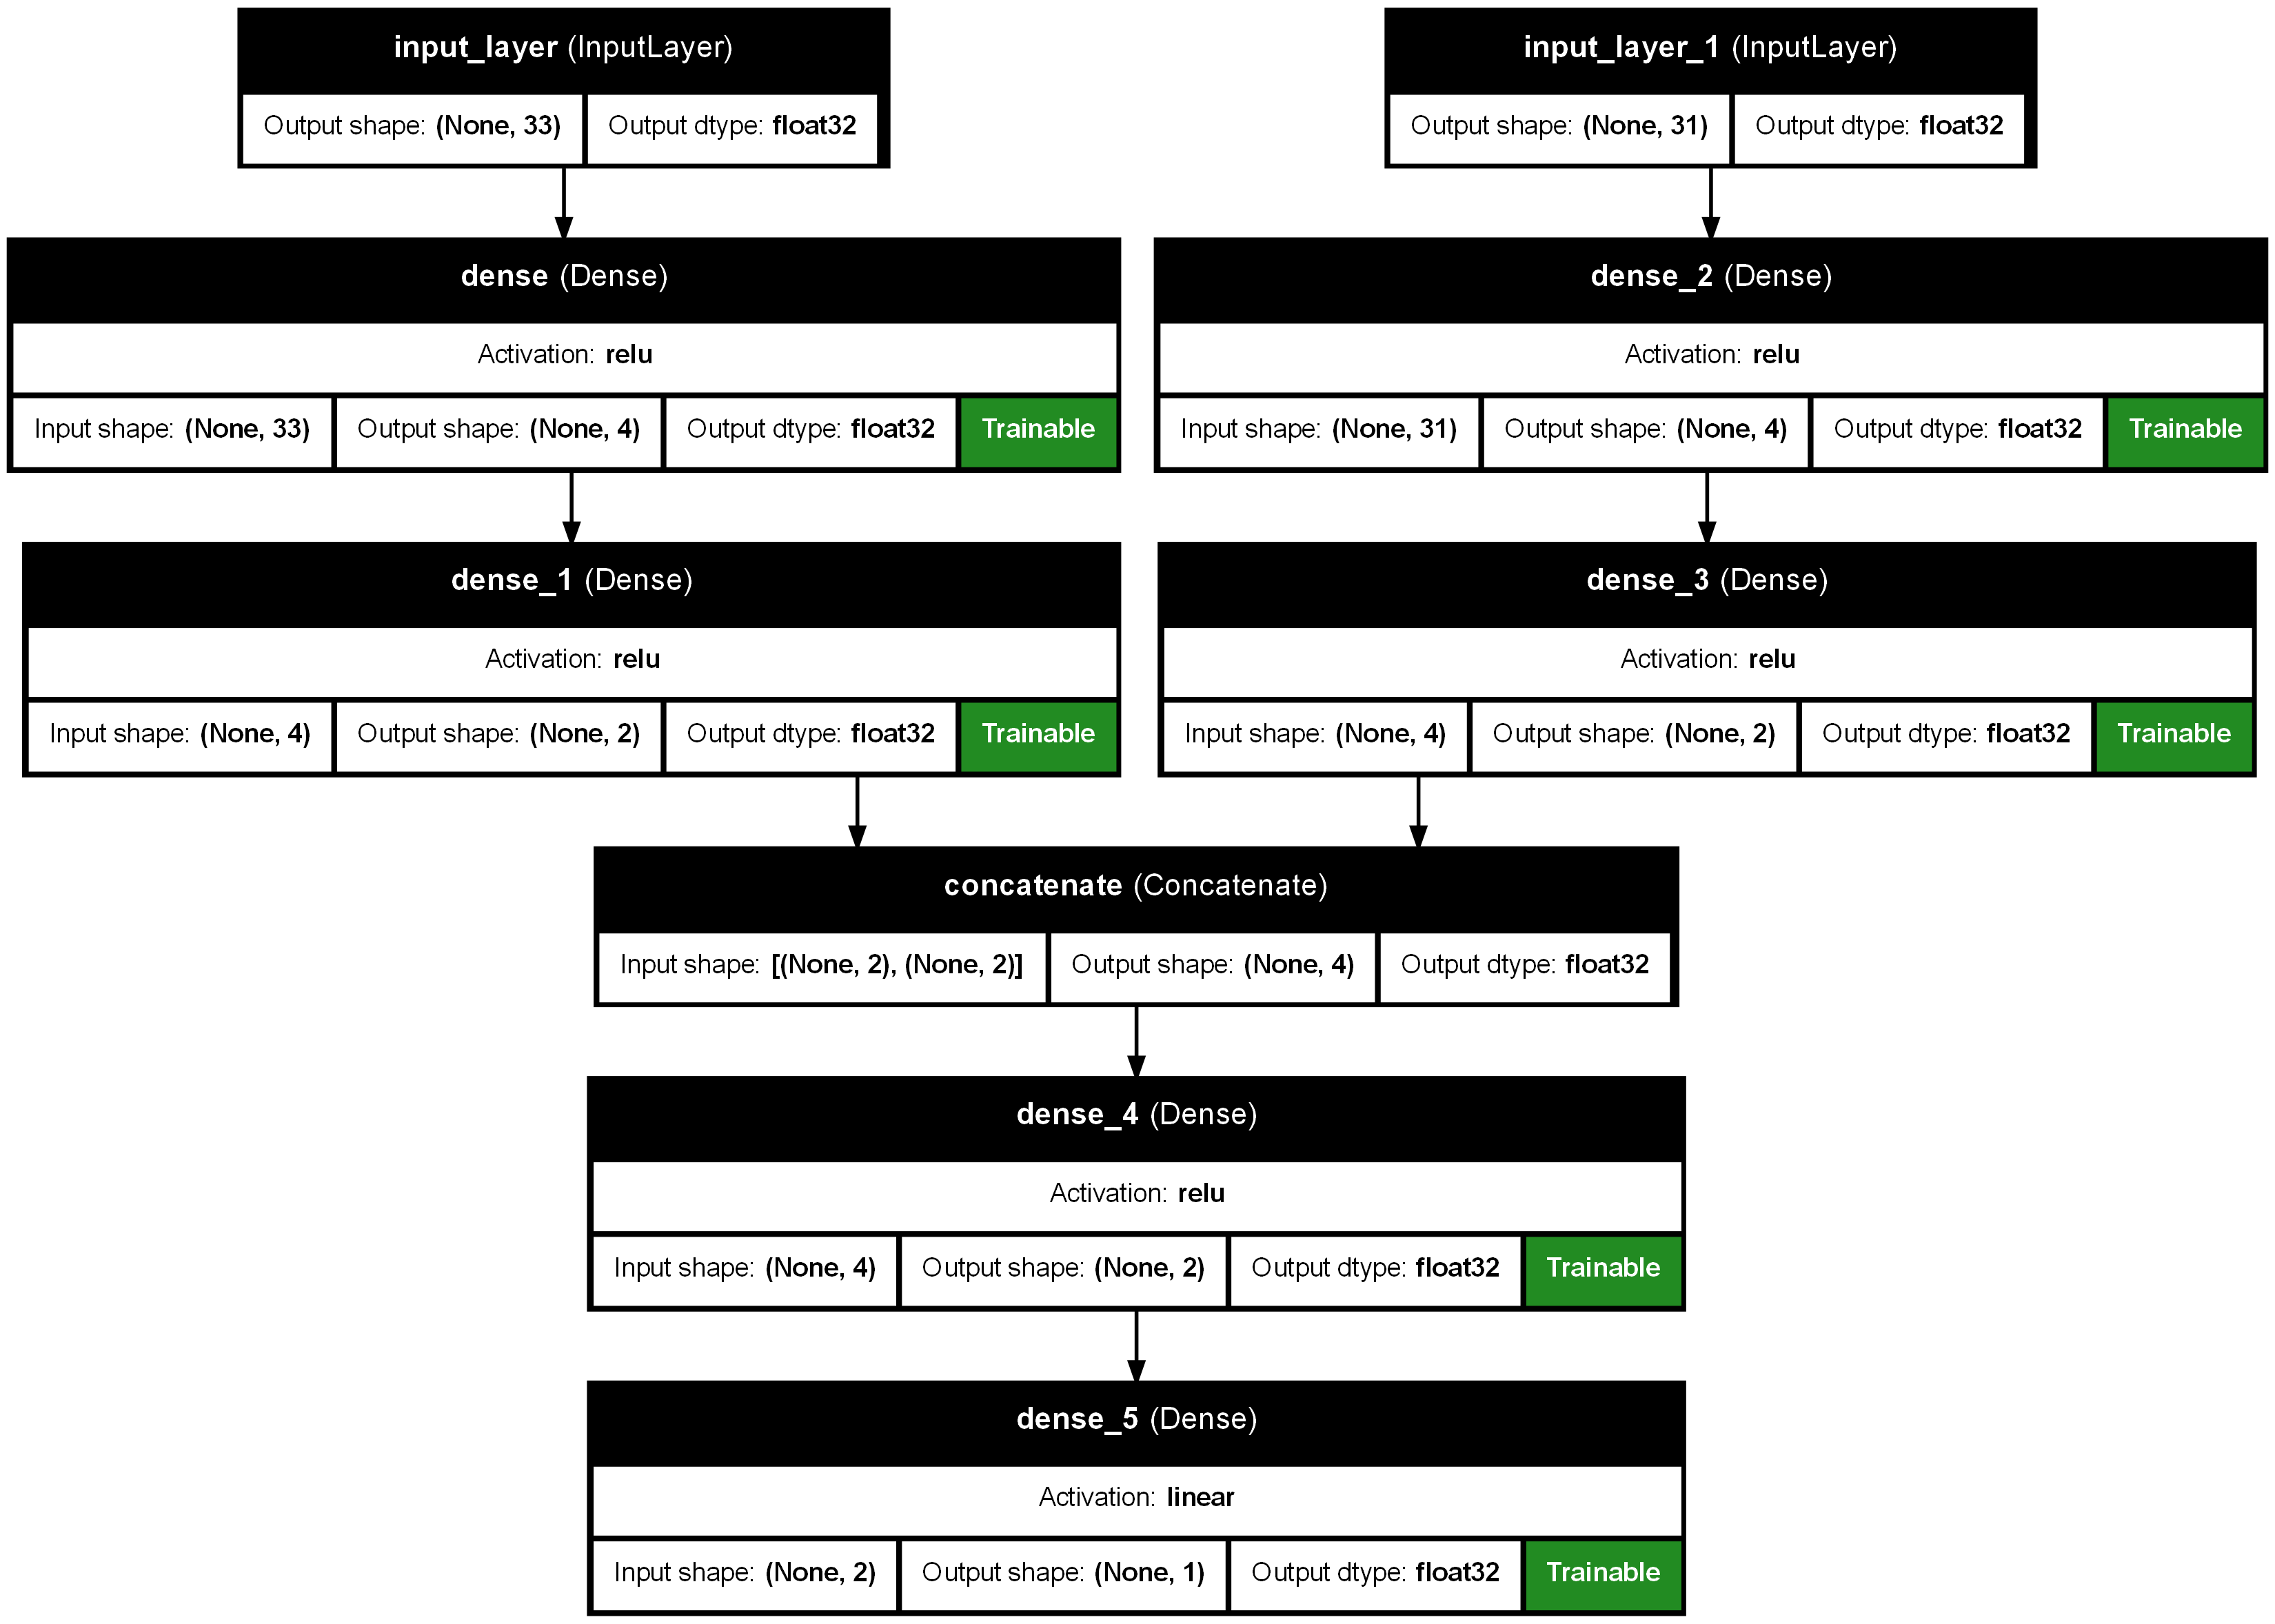

In [10]:
keras.utils.plot_model(
    model_mape,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True)

In [11]:
opt = Adam(learning_rate=1e-3, weight_decay=1e-3/round(np.sqrt(space_heating_data["train"].shape[0])))
model_mape.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [12]:
model_history = model_mape.fit(
    x=[space_heating_data["train"], others_data["train"]], 
    y=building_data["train"]["y"],
    epochs=1000,
    steps_per_epoch=100,
    validation_split=0.30
)

Epoch 1/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 105.5454 - val_loss: 83.1132
Epoch 2/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 - val_loss: 83.1132
Epoch 3/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80.7178 - val_loss: 64.4041
Epoch 4/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 - val_loss: 64.4041
Epoch 5/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.8477 - val_loss: 47.5481
Epoch 6/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 - val_loss: 47.5481
Epoch 7/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.2747 - val_loss: 44.7598
Epoch 8/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - val_loss: 44.7598
Epoch 9/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8540 - val_loss: 44.7443
Epoch 10/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00 - val_loss: 44.7443
Epoch 11/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.9923 - val_loss: 

In [13]:
model_mape.evaluate([space_heating_data["test"], others_data["test"]], building_data["test"]["y"])

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 72.6493


67.75556945800781

In [14]:
predictions = model_mape.predict([space_heating_data["test"], others_data["test"]])

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [15]:
predictions = pd.DataFrame({"predictions": predictions.reshape(-1)})
predictions.head()

,predictions
0,0.349497
1,0.349497
2,0.349497
3,0.349497
4,0.349497


In [16]:
cal_metrics(predictions["predictions"].to_numpy(), building_data["test"]["y"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,1.321395,378.23,-1.163597e+06,107.8,20.458872,1.872113,-1.32


In [17]:
def plot_history(model_hist):
    plt.plot(model_hist["loss"])
    plt.plot(model_hist["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

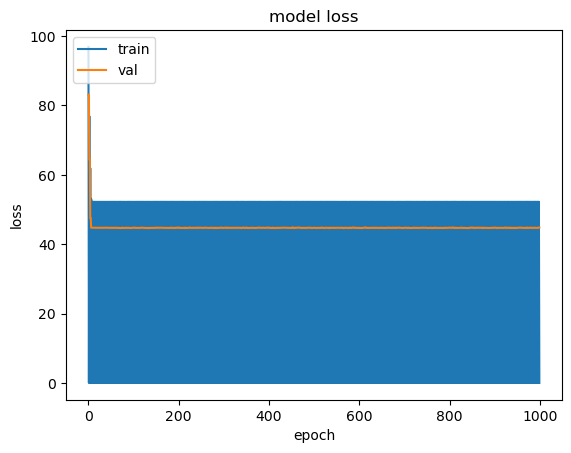

In [18]:
plot_history(model_history.history)

### Model testing with sMAPE

In [19]:
import tensorflow as tf

def calculate_smape_k(y_true, y_pred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(y_true) + tf.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(y_pred - y_true) / summ * 2.0
    return smape

In [20]:
model_smape = get_model()
opt2 = Adam(learning_rate=1e-3, weight_decay=1e-3/round(np.sqrt(space_heating_data["train"].shape[0])))
model_smape.compile(loss=calculate_smape_k, optimizer=opt2)

In [21]:
model_history_smape = model_smape.fit(
    x=[space_heating_data["train"], others_data["train"]], 
    y=building_data["train"]["y"],
    epochs=1000,
    steps_per_epoch=100,
    validation_split=0.30
)

Epoch 1/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.8201 - val_loss: 0.5323
Epoch 2/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.5323
Epoch 3/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4454 - val_loss: 0.4076
Epoch 4/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.4076
Epoch 5/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3400 - val_loss: 0.3862
Epoch 6/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.3862
Epoch 7/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3142 - val_loss: 0.3705
Epoch 8/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.3705
Epoch 9/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2935 - val_loss: 0.3529
Epoch 10/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.3529
Epoch 11/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2734 - val_loss: 0.3330
Epoch 12/1

In [22]:
model_smape.evaluate([space_heating_data["test"], others_data["test"]], building_data["test"]["y"])

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049


0.00590558210387826

In [23]:
predictions = model_smape.predict([space_heating_data["test"], others_data["test"]])
predictions = pd.DataFrame({"predictions": predictions.reshape(-1)})
cal_metrics(predictions["predictions"].to_numpy(), building_data["test"]["y"].to_numpy())

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,MAE,MAPE,R2_Score,SMAPE,nRMSE,RMSE,MASE
0,0.009545,0.62,0.999302,0.62,0.003552,0.035028,-0.01


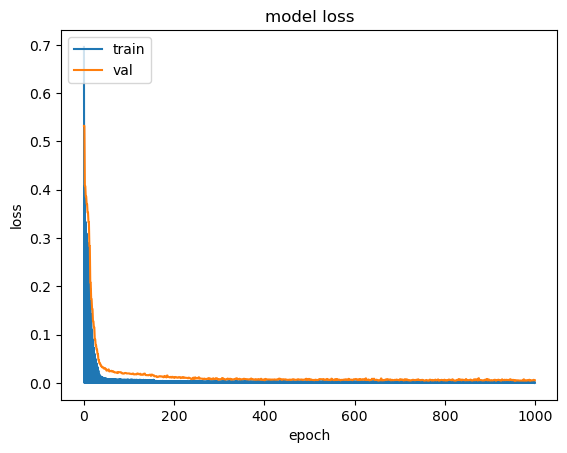

In [24]:
plot_history(model_history_smape.history)

### XAI

In [25]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [26]:
X100 = [space_heating_data["test"].iloc[:100, :].to_numpy(), 
        others_data["test"].iloc[:100, :].to_numpy()]

def predict_fxn(x):
    x = [x[0][0], x[1][0]]
    return model_smape.predict(x).flatten()

In [27]:
explainer = shap.DeepExplainer(model_smape, X100)

In [28]:
# shap_values = explainer.shap_values(X100)